In [53]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

**Data loading**

In [54]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar10

**Data preprocessing**

In [55]:
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32).squeeze()
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.int32).squeeze()

In [56]:
val_size = 1000
p = np.random.permutation(len(X_train))
X_train, y_train = X_train[p], y_train[p]
X_train, X_val, y_train, y_val = X_train[val_size:], X_train[:val_size], y_train[val_size:], y_train[:val_size]

print (f"X_train:{X_train.shape}, X_val:{X_val.shape}, y_train:{y_train.shape}, y_val:{y_val.shape}")

X_train:(49000, 32, 32, 3), X_val:(1000, 32, 32, 3), y_train:(49000,), y_val:(1000,)


**Model**

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, ReLU, LeakyReLU, Dropout, \
BatchNormalization, MaxPool2D, Add, AveragePooling2D, GlobalMaxPool2D, GlobalAveragePooling2D, \
ZeroPadding2D, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [58]:
USE_TPU = True
if USE_TPU:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # instantiate a distribution strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [59]:
# Create model based on DenseNet
class Cifar10(tf.keras.Model):
    def __init__(self, input_shape=(32, 32, 3), num_classes=10, activation=LeakyReLU, reg=2e-4, drop_rate=0.4):
        super(Cifar10, self).__init__()
        self.activation = activation
        self.reg = l2(reg)
        self.drop_rate = drop_rate
        self.kernel_init = he_uniform(seed=42)
        self.ch_axis = 3
        self.K = 32
        
        inputs = Input(shape=input_shape)
        x = Conv2D(64, 3, kernel_regularizer=self.reg, padding='same', use_bias=False)(inputs)
        x = BatchNormalization(axis=self.ch_axis)(x)
        x = self.activation()(x)
        x = MaxPool2D()(x)

        for i in [12, 24, 8]:
          d = self.dense_block(x, i)
          x = self.transition(d)

        x = GlobalAveragePooling2D()(d)
        x = Dropout(0.5)(x)
        x = Dense(128)(x)
        x = self.activation()(x)
                   
        outputs = Dense(num_classes, activation='softmax')(x)

        self.model = Model(inputs=inputs, outputs=outputs)

    
    def call(self, input_tensor, training=False):
        return self.model(input_tensor)
    
    def bn_relu_conv(self, x, filters, kernel_size, padding='valid', strides=1):
      x = BatchNormalization(axis=self.ch_axis)(x)
      x = self.activation()(x)
      x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides,
                 kernel_initializer=self.kernel_init, kernel_regularizer=self.reg, use_bias=False)(x)
      return x

    def transition(self, x):
      x = self.bn_relu_conv(x, int(x.shape[-1] // 2), 1, padding='same')
      if self.drop_rate:
        x = Dropout(self.drop_rate)(x)
      x = AveragePooling2D(2, strides=2)(x)
      return x

    def dense_block(self, x, n):
      for _ in range(n):
        x_tmp = x
        x = self.bn_relu_conv(x, self.K*4, 1)          
        x = self.bn_relu_conv(x, self.K, 3, padding='same')

        if self.drop_rate:
          x = Dropout(self.drop_rate)(x)

        x = Concatenate()([x_tmp, x])
      return x

In [60]:
# data preperations
def augment(image,label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.image.random_contrast(image, 0.7, 1.3)
  image = tf.image.resize_with_crop_or_pad(image, 48, 48)
  image = tf.image.random_crop(image, size=[32, 32, 3])

  return image,label

BATCH_SIZE = 1024
num_train_examples = len(X_train)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

augmented_train_batches = (
    train_dataset
    .cache()
    .shuffle(num_train_examples)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
    ) 

non_augmented_train_batches = (
    train_dataset
    .cache()
    .shuffle(num_train_examples)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
    )

validation_batches = (
    val_dataset
    .batch(BATCH_SIZE)
    )

In [61]:
learning_rate = 1e-3
clipnorm = 1e-3
lrr = ReduceLROnPlateau(monitor='val_loss',
                        factor=0.7,
                        patience=7,
                        min_lr=1e-6, 
                        verbose=1)

opt = tf.keras.optimizers.Adam(learning_rate, clipnorm=clipnorm)

In [62]:
if USE_TPU:
    with tpu_strategy.scope():
        model = Cifar10()
        model.compile(opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
else:
    model = Cifar10()
    model.compile(opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [63]:
history = model.fit(augmented_train_batches, epochs=300, validation_data=validation_batches, callbacks=[lrr])

Train for 48 steps, validate for 1 steps
Epoch 1/300
48/48 [==============================] - 154s 3s/step - loss: 4.8272 - accuracy: 0.3024 - val_loss: 5.7311 - val_accuracy: 0.2380
Epoch 2/300
48/48 [==============================] - 6s 132ms/step - loss: 3.9291 - accuracy: 0.4626 - val_loss: 6.2494 - val_accuracy: 0.2670
Epoch 3/300
48/48 [==============================] - 6s 128ms/step - loss: 3.3406 - accuracy: 0.5351 - val_loss: 4.9198 - val_accuracy: 0.3740
Epoch 4/300
48/48 [==============================] - 6s 132ms/step - loss: 2.9066 - accuracy: 0.5778 - val_loss: 5.6296 - val_accuracy: 0.3270
Epoch 5/300
48/48 [==============================] - 6s 128ms/step - loss: 2.5690 - accuracy: 0.6113 - val_loss: 3.2483 - val_accuracy: 0.4710
Epoch 6/300
48/48 [==============================] - 6s 131ms/step - loss: 2.3212 - accuracy: 0.6314 - val_loss: 4.4413 - val_accuracy: 0.3560
Epoch 7/300
48/48 [==============================] - 6s 128ms/step - loss: 2.0972 - accuracy: 0.6554 -

48/48 [==============================] - 6s 129ms/step - loss: 0.6681 - accuracy: 0.8466 - val_loss: 0.7469 - val_accuracy: 0.8240
Epoch 57/300
48/48 [==============================] - 6s 132ms/step - loss: 0.6640 - accuracy: 0.8499 - val_loss: 0.7141 - val_accuracy: 0.8460
Epoch 58/300
48/48 [==============================] - 6s 132ms/step - loss: 0.6611 - accuracy: 0.8503 - val_loss: 0.8177 - val_accuracy: 0.8150
Epoch 59/300
48/48 [==============================] - 6s 130ms/step - loss: 0.6617 - accuracy: 0.8482 - val_loss: 0.7170 - val_accuracy: 0.8420
Epoch 60/300
48/48 [==============================] - 6s 131ms/step - loss: 0.6538 - accuracy: 0.8508 - val_loss: 0.8952 - val_accuracy: 0.7810
Epoch 61/300
48/48 [==============================] - 6s 131ms/step - loss: 0.6460 - accuracy: 0.8514 - val_loss: 0.7698 - val_accuracy: 0.8160
Epoch 62/300
48/48 [==============================] - 6s 130ms/step - loss: 0.6508 - accuracy: 0.8504 - val_loss: 0.6999 - val_accuracy: 0.8490
Epoch

Epoch 110/300
48/48 [==============================] - 6s 128ms/step - loss: 0.4253 - accuracy: 0.9110 - val_loss: 0.4792 - val_accuracy: 0.9020
Epoch 111/300
48/48 [==============================] - 6s 132ms/step - loss: 0.4087 - accuracy: 0.9168 - val_loss: 0.6300 - val_accuracy: 0.8750
Epoch 112/300
48/48 [==============================] - 6s 128ms/step - loss: 0.4025 - accuracy: 0.9187 - val_loss: 0.4656 - val_accuracy: 0.9050
Epoch 113/300
48/48 [==============================] - 6s 134ms/step - loss: 0.4034 - accuracy: 0.9174 - val_loss: 0.4780 - val_accuracy: 0.8980
Epoch 114/300
48/48 [==============================] - 6s 130ms/step - loss: 0.4063 - accuracy: 0.9160 - val_loss: 0.4782 - val_accuracy: 0.9080
Epoch 115/300
48/48 [==============================] - 6s 131ms/step - loss: 0.3966 - accuracy: 0.9196 - val_loss: 0.4426 - val_accuracy: 0.9190
Epoch 116/300
48/48 [==============================] - 6s 132ms/step - loss: 0.4021 - accuracy: 0.9161 - val_loss: 0.4626 - val_ac

Epoch 161/300
48/48 [==============================] - 6s 132ms/step - loss: 0.2677 - accuracy: 0.9548 - val_loss: 0.4313 - val_accuracy: 0.9290
Epoch 162/300
48/48 [==============================] - 6s 133ms/step - loss: 0.2642 - accuracy: 0.9554 - val_loss: 0.4391 - val_accuracy: 0.9290
Epoch 163/300
48/48 [==============================] - 6s 133ms/step - loss: 0.2627 - accuracy: 0.9565 - val_loss: 0.4261 - val_accuracy: 0.9280
Epoch 164/300
48/48 [==============================] - 6s 128ms/step - loss: 0.2596 - accuracy: 0.9577 - val_loss: 0.4320 - val_accuracy: 0.9340
Epoch 165/300
48/48 [==============================] - 6s 132ms/step - loss: 0.2614 - accuracy: 0.9576 - val_loss: 0.4420 - val_accuracy: 0.9270
Epoch 166/300
48/48 [==============================] - 6s 133ms/step - loss: 0.2591 - accuracy: 0.9580 - val_loss: 0.4540 - val_accuracy: 0.9250
Epoch 167/300
47/48 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9580
Epoch 00167: ReduceLROnPlateau re

Epoch 210/300
48/48 [==============================] - 6s 134ms/step - loss: 0.2319 - accuracy: 0.9669 - val_loss: 0.4531 - val_accuracy: 0.9260
Epoch 211/300
48/48 [==============================] - 6s 128ms/step - loss: 0.2298 - accuracy: 0.9664 - val_loss: 0.4498 - val_accuracy: 0.9260
Epoch 212/300
48/48 [==============================] - 6s 131ms/step - loss: 0.2295 - accuracy: 0.9674 - val_loss: 0.4596 - val_accuracy: 0.9260
Epoch 213/300
48/48 [==============================] - 6s 128ms/step - loss: 0.2331 - accuracy: 0.9659 - val_loss: 0.4544 - val_accuracy: 0.9250
Epoch 214/300
48/48 [==============================] - 6s 133ms/step - loss: 0.2304 - accuracy: 0.9666 - val_loss: 0.4580 - val_accuracy: 0.9230
Epoch 215/300
48/48 [==============================] - 6s 133ms/step - loss: 0.2279 - accuracy: 0.9680 - val_loss: 0.4501 - val_accuracy: 0.9250
Epoch 216/300
47/48 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9665
Epoch 00216: ReduceLROnPlateau re

48/48 [==============================] - 6s 134ms/step - loss: 0.2266 - accuracy: 0.9679 - val_loss: 0.4575 - val_accuracy: 0.9270
Epoch 263/300
48/48 [==============================] - 6s 128ms/step - loss: 0.2233 - accuracy: 0.9694 - val_loss: 0.4563 - val_accuracy: 0.9280
Epoch 264/300
48/48 [==============================] - 6s 134ms/step - loss: 0.2269 - accuracy: 0.9674 - val_loss: 0.4578 - val_accuracy: 0.9280
Epoch 265/300
48/48 [==============================] - 6s 129ms/step - loss: 0.2263 - accuracy: 0.9681 - val_loss: 0.4561 - val_accuracy: 0.9280
Epoch 266/300
48/48 [==============================] - 6s 134ms/step - loss: 0.2267 - accuracy: 0.9680 - val_loss: 0.4552 - val_accuracy: 0.9290
Epoch 267/300
48/48 [==============================] - 6s 131ms/step - loss: 0.2259 - accuracy: 0.9683 - val_loss: 0.4560 - val_accuracy: 0.9290
Epoch 268/300
48/48 [==============================] - 6s 134ms/step - loss: 0.2278 - accuracy: 0.9673 - val_loss: 0.4569 - val_accuracy: 0.9290

Plot model's history

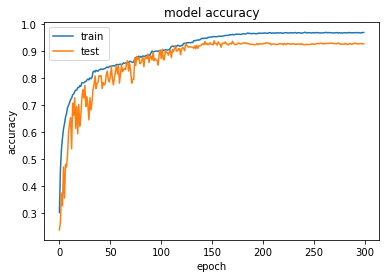

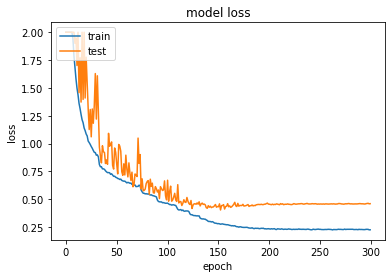

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'learning rate'], loc='upper left')
plt.show()

plt.plot(np.array(history.history['loss']).clip(max=2))
plt.plot(np.array(history.history['val_loss']).clip(max=2))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Test**

In [65]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 28s 3ms/sample - loss: 0.4121 - accuracy: 0.9329


[0.4121346180677414, 0.93289995]